Objective:-

1) Convert reviews of "Amazon Fine Food Review" dataset into vectors using :-
- Bag of words.
- TF-IDF
- Average Word2vec
- TF-IDF Word2vec

2) Reduce dimensions of vectors using t-SNE.

3) Plot graph on reduced vectors.

In [3]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

import sqlite3
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from nltk.stem.porter import PorterStemmer

import re
# Tutorial about Python regular expressions: https://pymotw.com/2/re/
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle

from tqdm import tqdm
import os

C:\Users\pavan\Anaconda3\lib\site-packages\gensim\utils.py:1212: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")


In [4]:
# using the SQLite Table to read data.
con = sqlite3.connect('C:\\Users\\pavan\\Desktop\\Applied AI course\\amazon-food-reviews_dataset\\database.sqlite') 
#filtering only positive and negative reviews i.e. 
# not taking into consideration those reviews with Score=3
filtered_data = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3 """, con) 


# Give reviews with Score>3 a positive rating, and reviews with a score<3 a negative rating.
def partition(x):
    if x < 3:
        return 'negative'
    return 'positive'

#changing reviews with score less than 3 to be positive and vice-versa
actualScore = filtered_data['Score']
positiveNegative = actualScore.map(partition) 
filtered_data['Score'] = positiveNegative
print("Number of data points in our data", filtered_data.shape)
filtered_data.head()

Number of data points in our data (525814, 10)


,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,positive,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,negative,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,positive,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,negative,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,positive,1350777600,Great taffy,Great taffy at a great price. There was a wid...


In [6]:
#Removes duplicate data from dataset that are repeated.

#Sorting data according to ProductId in ascending order
sorted_data=filtered_data.sort_values('ProductId', axis=0, ascending=True,\
                                      inplace=False, kind='quicksort',\
                                      na_position='last')
#Deduplication of entries
final=sorted_data.drop_duplicates(subset={"UserId","ProfileName","Time","Text"},\
                                  keep='first', inplace=False)
final=final[final.HelpfulnessNumerator<=final.HelpfulnessDenominator]
final.head()
final.shape

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
138706,150524,0006641040,ACITT7DI6IDDL,shari zychinski,0,0,positive,939340800,EVERY book is educational,this witty little book makes my son laugh at l...
138688,150506,0006641040,A2IW4PEEKO2R0U,Tracy,1,1,positive,1194739200,"Love the book, miss the hard cover version","I grew up reading these Sendak books, and watc..."
138689,150507,0006641040,A1S4A3IQ2MU7V4,"sally sue ""sally sue""",1,1,positive,1191456000,chicken soup with rice months,This is a fun way for children to learn their ...
138690,150508,0006641040,AZGXZ2UUK6X,"Catherine Hallberg ""(Kate)""",1,1,positive,1076025600,a good swingy rhythm for reading aloud,This is a great little book to read aloud- it ...
138691,150509,0006641040,A3CMRKGE0P909G,Teresa,3,4,positive,1018396800,A great way to learn the months,This is a book of poetry about the months of t...


In [7]:
"""
This code snippet does text preprocessing
"""
def cleanhtml(sentence): #function to clean the html-tags
    cleanr = re.compile('<.*?>')
    cleantext = re.sub(cleanr, ' ', sentence)
    return cleantext
def cleanpunc(sentence): #function to clean the word of any punctuation/special characters
    cleaned = re.sub(r'[?|!|\'|"|#]',r'',sentence)
    cleaned = re.sub(r'[.|,|)|(|\|/]',r' ',cleaned)
    return  cleaned
stop = set(stopwords.words('english')) 
sno = nltk.stem.SnowballStemmer('english') #initialising the snowball stemmer
final_text = []
for index in range(len(final['Text'])):
    filtered_sentence=[]
    sent=cleanhtml(final['Text'].iloc[index]) # remove HTMl tags
    for w in sent.split():
        for cleaned_words in cleanpunc(w).split():
            if((cleaned_words.isalpha()) & (len(cleaned_words)>2)):
                cleaned_words = cleaned_words.lower()
                if(cleaned_words not in stop):
                    s=(sno.stem(cleaned_words))
                    filtered_sentence.append(s)
                else:
                    continue
            else:
                continue 
    str1 = " ".join(filtered_sentence) #final cleaned string of words
    final_text.append(str1)

In [15]:
#Choosing 1000 positive and negative points
positive_count =0
negative_count = 0
data_text=[]
data_label = []
for index in range(len(final['Score'])):
    if final['Score'].iloc[index] == 'positive' and positive_count < 1000:
        data_text.append(final_text[index])
        data_label.append(final['Score'].iloc[index])
        positive_count+=1
    elif final['Score'].iloc[index] == 'positive' and positive_count >= 1000:
        continue
    elif final['Score'].iloc[index] == 'negative' and negative_count < 1000:
        data_text.append(final_text[index])
        data_label.append(final['Score'].iloc[index])
        negative_count += 1
    else:
        break

In [16]:
amazon_data_text = pd.Series(data_text)
amazon_data_label = pd.Series(data_label)
print(amazon_data_text.shape)
print(amazon_data_label.shape)

(2000,)
(2000,)


In [17]:
#Converts text to vectors by BoW
count_vect = CountVectorizer() #in scikit-learn
final_counts = count_vect.fit_transform(amazon_data_text)
print("the type of count vectorizer ",type(final_counts))
print("the shape of out text BOW vectorizer ",final_counts.get_shape())
print("the number of unique words ", final_counts.get_shape()[1])

the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text BOW vectorizer  (2000, 7125)
the number of unique words  7125


In [30]:
# Dimension reduction through t-SNE for BoW
from sklearn.manifold import TSNE
model = TSNE(n_components=2,random_state=0,perplexity=850)
tsne_data = model.fit_transform(final_counts.toarray())
print("Shape of t-SNE reduced data = ",tsne_data.shape)

#Creating new dataframe which helps us in plotting

tsne_data1 = np.vstack((tsne_data.T, amazon_data_label)).T
tsne_df = pd.DataFrame(data=tsne_data1, columns=("Dim_1", "Dim_2", "label"))

Shape of t-SNE reduced data =  (2000, 2)


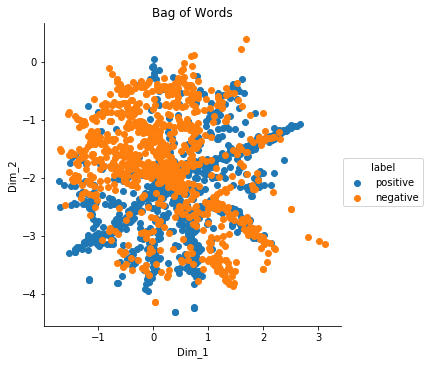

In [34]:
#Plotting result of tsne for BoW
sns.FacetGrid(tsne_df, hue="label", size=5).map(plt.scatter, 'Dim_1', 'Dim_2').add_legend()
plt.title('Bag of Words')
plt.show()

- The model Bag of words is representation of text that tells occurence of words within it.
- It considers two things: A vocabulary of known words, a measure of the presence of known words(uni-grams).

In [25]:
#Converts text to vectors by TFIDF
tf_idf_vect = TfidfVectorizer() #in scikit-learn
final_tf_idf = tf_idf_vect.fit_transform(amazon_data_text)
final_tf_idf.get_shape()

(2000, 7125)

In [28]:
# Dimension reduction through t-SNE for tf_idf
from sklearn.manifold import TSNE
tf_idf_model = TSNE(n_components=2,random_state=0,perplexity=650)
tsne_tf_idf_data = tf_idf_model.fit_transform(final_tf_idf.toarray())
print("Shape of t-SNE reduced data = ",tsne_tf_idf_data.shape)

#Creting new dataframe which helps us in plotting

tsne_tf_idf_data1 = np.vstack((tsne_tf_idf_data.T, amazon_data_label)).T
tsne_tf_idf_df = pd.DataFrame(data=tsne_tf_idf_data1, columns=("Dim_1", "Dim_2", "label"))

Shape of t-SNE reduced data =  (2000, 2)


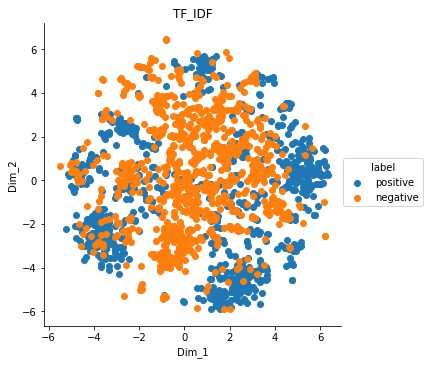

In [37]:
#Plotting result of tsne for TFIDF
sns.FacetGrid(tsne_tf_idf_df, hue="label", size=5).map(plt.scatter, 'Dim_1', 'Dim_2').add_legend()
plt.title('TF_IDF')
plt.show()

- TF IDF is more advanced than Bag of words.
- It finds word's TF amd IDF and calculate it's weightage by their product.
- Unlike Bag of words it accepts multiple words(n-grams).
- End vectors have high dimensions compared to other algorithms.

In [45]:
# Train your own Word2Vec model using your own text corpus
import gensim
from gensim.models import Word2Vec
from gensim.models import KeyedVectors

i=0
list_of_sent=[]
for sent in amazon_data_text:
    filtered_sentence=[]
    sent=cleanhtml(sent)
    for w in sent.split():
        for cleaned_words in cleanpunc(w).split():
            if(cleaned_words.isalpha()):
                filtered_sentence.append(cleaned_words.lower())
            else:
                continue
    list_of_sent.append(filtered_sentence)
# min_count = 5 considers only words that occured atleast 5 times
w2v_model=gensim.models.Word2Vec(list_of_sent,min_count=5,size=50, workers=4)
                    

In [46]:
#Aerage Word2Vec
#Converts text to vectors by Average Word2Vec

sent_vectors = [];
for sent in list_of_sent: 
    sent_vec = np.zeros(50) # as word vectors are of zero length
    cnt_words =0;
    for word in sent: # for each word in a review/sentence
        try:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
        except:
            pass
    sent_vec /= cnt_words
    sent_vectors.append(sent_vec)


In [47]:
avg_w2v = np.asmatrix(sent_vectors)
avg_w2v.shape

(2000, 50)

In [49]:
# Dimension reduction through t-SNE for Avg_Word2Vec

from sklearn.manifold import TSNE
avg_w2v_model = TSNE(n_components=2,random_state=0,perplexity=650)
tsne_avg_w2v_data = avg_w2v_model.fit_transform(avg_w2v)
print("Shape of t-SNE reduced data = ",tsne_avg_w2v_data.shape)

#Creating new dataframe which helps us in plotting

tsne_avg_w2v_data1 = np.vstack((tsne_avg_w2v_data.T, amazon_data_label)).T
tsne_avg_w2v_df = pd.DataFrame(data=tsne_avg_w2v_data1, columns=("Dim_1", "Dim_2", "label"))

Shape of t-SNE reduced data =  (2000, 2)


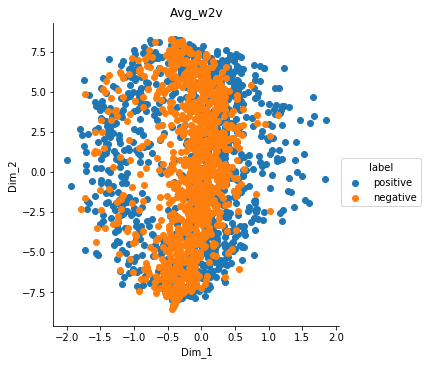

In [52]:
#Plotting result of tsne for Avg_Word2Vec
sns.FacetGrid(tsne_avg_w2v_df, hue="label", size=5).map(plt.scatter, 'Dim_1', 'Dim_2').add_legend()
plt.title('Avg_w2v')
plt.show()

- Unlike above two alogorithms it converts the whole sentence into vectors.
- It assumes all words have same weightage.
- The most important thing is that it take words semantics into consideraton

In [ ]:
# Converts text to vectors by TF-IDF  weighted Word2Vec
#Converts text to vectors by BoW
tf_idf_vect = TfidfVectorizer() 
final_tf_idf = tf_idf_vect.fit_transform(amazon_data_text)
tfidf_feat = tf_idf.get_feature_names()# tfidf columns/names

# final_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf
tfidf_sent_vectors = [];
row=0;

for sent in list_of_sent: 
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0;
    for word in sent: # for each word in a review
        try:
            vec = w2v_model.wv[word]
            #obtain the tf_idf word in a review
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
        except:
            pass
    sent_vec /=   weight_sum
    tfidf_sent_vectors.append(sent_vec)
    row+=1




In [57]:
tf_idf_w2v = np.asmatrix(sent_vectors)
tf_idf_w2v.shape

(2000, 50)

In [58]:
# Dimension reduction through t-SNE for TFIDF Word2Vec

from sklearn.manifold import TSNE
tf_idf_w2v_model = TSNE(n_components=2,random_state=0,perplexity=650)
tsne_tf_idf_w2v_data = tf_idf_w2v_model.fit_transform(tf_idf_w2v)
print("Shape of t-SNE reduced data = ",tsne_tf_idf_w2v_data.shape)

#Creating new dataframe which helps us in plotting

tsne_tf_idf_w2v_data1 = np.vstack((tsne_tf_idf_w2v_data.T, amazon_data_label)).T
tsne_tf_idf_w2v_df = pd.DataFrame(data=tsne_tf_idf_w2v_data1, columns=("Dim_1", "Dim_2", "label"))

Shape of t-SNE reduced data =  (2000, 2)


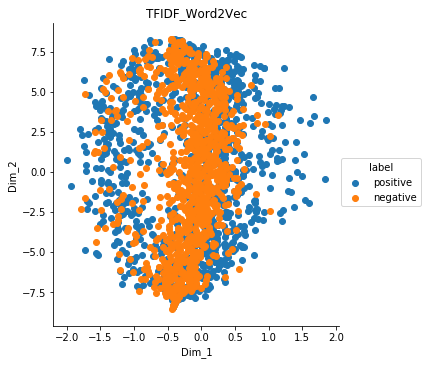

In [59]:
#Plotting result of tsne for TFIDF Word2Vec
sns.FacetGrid(tsne_avg_w2v_df, hue="label", size=5).map(plt.scatter, 'Dim_1', 'Dim_2').add_legend()
plt.title('TFIDF_Word2Vec')
plt.show()



- Converts the whole sentence into words and takeswords semantics into consideration
- Unlike Avg_W2V it calculate every words weightage.

Conclusion:-

- The last two algorithms(i.e. word2vec algorithms) are much better than BOW and TF IDF because they remove outliers 
   or less appered words and thay keep words with same symantics together.
- By reducing dimension with t-SNE with diffrent hyperparameters, I got the result that "TF IDF word2vec" have better
   performance than other three to separate positive and negative reviews.